In [ ]:
%load_ext autoreload
%autoreload 2

from sbi_feature_importance.experiment_helper import SimpleDB
from sbi_feature_importance.utils import skip_dims, extract_tags
from sbi_feature_importance.toymodels import GLM
from sbi_feature_importance.analysis import plot_iqrchanges

from sbi.analysis import pairplot

import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns

import time
import IPython.display as IPd
from svgutils.compose import *

In [ ]:
data_db = SimpleDB("../results/fig2", "r")

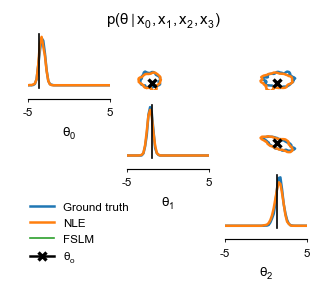

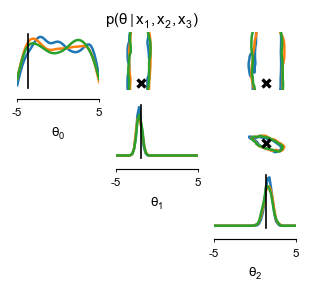

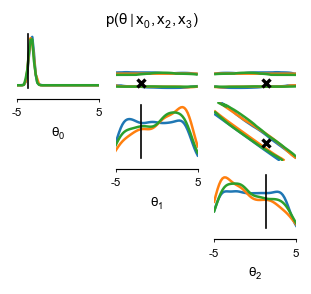

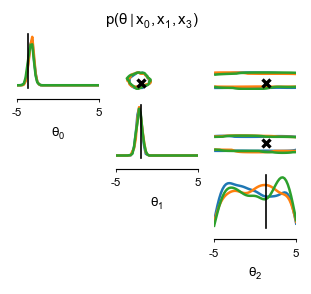

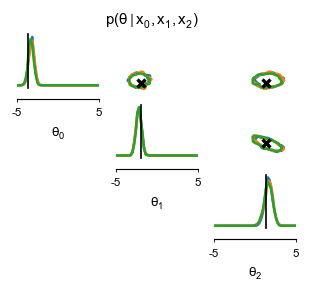

In [3]:
all_dims = list(range(4))
dims = [all_dims] + skip_dims(all_dims)
prior = data_db.query("prior")
limits = torch.stack([prior.base_dist.low, prior.base_dist.high]).T

sampling_method = "mcmc"

all_samples = {key:val for key,val in data_db.find(sampling_method).items() if "posterior" not in key and "fixed" not in key}

seed = 0
marker_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

for fig_label, subset in zip(["a", "b", "c", "d", "e"], dims):
    glm = GLM(prior)
    gt_sample = glm.sample_posterior((1000,), context=data_db.query("x_o_fixed"), xdims=subset)
    direct_sample = [val for key, val in all_samples.items() if f"_{seed}_{subset}" in key and "direct" in key][0]
    posthoc_sample = [val for key, val in all_samples.items() if f"_{seed}_{subset}" in key and "posthoc" in key][0]

    with mpl.rc_context(fname=".mpl_rc"):
        if fig_label == "a":
            blueto = "tab:blue"
            orangeto = "tab:orange"
            greento = "tab:green"
            redto = "tab:blue"
            legend_labels = ["Ground truth", "NLE", "FSLM", r"$\theta_o$"]
            samples = [gt_sample, posthoc_sample]
        if fig_label in ["b","c","d","e"]:
            blueto = "tab:blue"
            orangeto = "tab:orange"
            greento = "tab:green"
            redto = "tab:blue"
            legend_labels = ["Ground truth", "NLE", "FSLM", r"$\theta_o$"]
            samples = [gt_sample, direct_sample, posthoc_sample]
        fig, axes = pairplot(
            samples,
            upper="contour",
            diag="kde",
            limits=limits,
            ticks=limits,
            points=data_db.query(f"theta_o_{seed}"),
            labels=[r"$\theta_{%s}$" %i for i in range(3)],
            points_offdiag={"markersize": 5, "mew": 2, "marker": "x", "lw": 1.5, "alpha":1},
            points_diag={"lw": 1, "alpha":1},
            points_colors=["black"],
            contour_offdiag={"levels": torch.logspace(-3, -0.000001, 1), 'percentile':False},
            figsize=(3,2.1),
        )

        colors = {"#1f77b4":blueto, "#ff7f0e":orangeto, "#2ca02c":greento, "#d62728":redto, "black":"black", "tab:blue":blueto,"tab:orange":orangeto,"tab:green":greento,"tab:red":redto}
        for axe in axes:
            for ax in axe:
                for color, line in zip(colors, ax.collections):
                    line.set_edgecolor(colors['#%02x%02x%02x' %tuple((line.get_edgecolor()[0,:3]*255).astype(int))])
                for color, line in zip(colors, ax.lines):
                    if line.get_color() in marker_colors:
                        pass
                    else:
                        line.set_color(colors[line.get_color()])
        if fig_label == "a":
            leg = fig.legend(legend_labels, loc=(0.08, 0.08))
            leg.legendHandles[2].set_color(greento)
        plt.suptitle(r"$p(\theta \mid " + (", ").join([f"x_{i}" for i in subset]) + ")$", size=9)
        plt.savefig(f"../paper/fig2/svg/panel_{fig_label}.svg")
        plt.show()

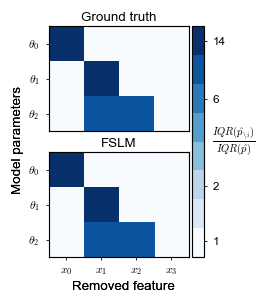

In [13]:
gt_data = []
fslm_data = []
for subset in dims[1:]:
    glm = GLM(prior)
    gt_sample = glm.sample_posterior((1000,), context=data_db.query("x_o_fixed"), xdims=subset)
    # direct_sample = [val for key, val in all_samples.items() if f"_{seed}_{subset}" in key and "direct" in key][0]
    posthoc_sample = [val for key, val in all_samples.items() if f"_{seed}_{subset}" in key and "posthoc" in key][0]
    fslm_data.append(posthoc_sample)
    gt_data.append(gt_sample)

fslm_base_sample = [val for key, val in all_samples.items() if f"_{seed}_{dims[0]}" in key and "posthoc" in key][0]
gt_base_sample = glm.sample_posterior((1000,), context=data_db.query("x_o_fixed"), xdims=subset)

with mpl.rc_context(fname=".mpl_rc"):
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(3.5,2.5))
    for ax, data, base_sample, label in zip(axes, [gt_data, fslm_data], [gt_base_sample, fslm_base_sample], ["Ground truth", "FSLM"]):
        active_ax = plt.axes(ax)
        im = plot_iqrchanges(data, base_sample, zlims=[1,14], add_cbar=False, agg_with="median", n_colors=8)
        active_ax.set_title(label, size=8, pad=3)
        active_ax.set_xticks(range(4))
        active_ax.set_yticks(range(3))
        active_ax.set_yticklabels([r"$\theta_" + "{%s}$"%i for i in range(3)])
        active_ax.set_xticklabels([r"$x_" + "{%s}$"%i for i in range(4)])
        active_ax.tick_params(axis="both", which="major")
        axes[0].tick_params(axis="x", which="both", size=0)
        fig.text(0.62, 0.01, "Removed feature", ha="center", va="center")
        yticktype = type(ax.get_yticks()[0])
        fig.text(
            0.37,
            0.5,
            "Model parameters",
            ha="center",
            va="center",
            rotation=90,
        )
        active_ax.spines['right'].set_visible(True)
        active_ax.spines['top'].set_visible(True)

    plt.subplots_adjust(wspace=0, hspace=0.2)
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(),pad=0.01)
    cbar.ax.get_yaxis().labelpad = 5
    cbar.set_label(r"$\frac{IQR(\hat{p}_{\backslash i})}{IQR(\hat{p})}$", rotation=0, ha="center", va="center", size=9)
    vmin, vmax = im.get_clim()

    cticks = (
        torch.logspace(
            torch.log10(torch.tensor(vmin)), torch.log10(torch.tensor(vmax)), 4
        )
        .round().int()
        .numpy()
    )
    cbar.set_ticks(cticks+np.array([0.2,0.25,0.1,-2.2])) # center ticks in bins
    cbar.set_ticklabels(cticks)
    cbar.ax.minorticks_off()
    plt.savefig(f"../paper/fig2/svg/panel_f.svg")


In [7]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("20.3cm", "12.2cm",           
Panel(
        SVG("../paper/fig2/svg/panel_a.svg").scale(svg_scale),
        Text("a", -5, 2.0, **kwargs_text),
).move(10, 20),

Panel(
        SVG("../paper/fig2/svg/panel_b.svg").scale(svg_scale),
        Text("b", -5, 2.0, **kwargs_text),
).move(270, 20),

Panel(
        SVG("../paper/fig2/svg/panel_c.svg").scale(svg_scale),
        Text("c", -5, 2.0, **kwargs_text),
).move(520, 20),

Panel(
        SVG("../paper/fig2/svg/panel_d.svg").scale(svg_scale),
        Text("d", -5, 2.0, **kwargs_text),
).move(10, 240),

Panel(
        SVG("../paper/fig2/svg/panel_e.svg").scale(svg_scale),
        Text("e", -5, 2.0, **kwargs_text),
).move(270, 240),

Panel(
        SVG("../paper/fig2/svg/panel_f.svg").scale(svg_scale),
        Text("f", -35, 12.0, **kwargs_text),
).move(550, 230),

)

!mkdir -p fig
f.save("../paper/fig2/svg/fig.svg")
svg("../paper/fig2/svg/fig.svg")